In [1]:
!pip install trimesh

In [2]:
import glob
import trimesh
import numpy as np
import random
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt
import os
import seaborn as sns
import shutil
keras.utils.set_random_seed(seed=42)

# Load dataset
* We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40 dataset. First download the data:

In [3]:
# download_path="/kaggle/working/"
# DATA_DIR = keras.utils.get_file("modelnet.zip","http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",extract=True)
# extracted_folder = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
# target_folder=os.path.join(download_path,"MobileNet10")

# if os.path.exists(target_folder):
#     shutil.rmtree(target_folder)
# shutil.move(extracted_folder,target_folder)
# print(f"Dataset successfully downloaded to: {target_folder}")

# Visualize Images with Points

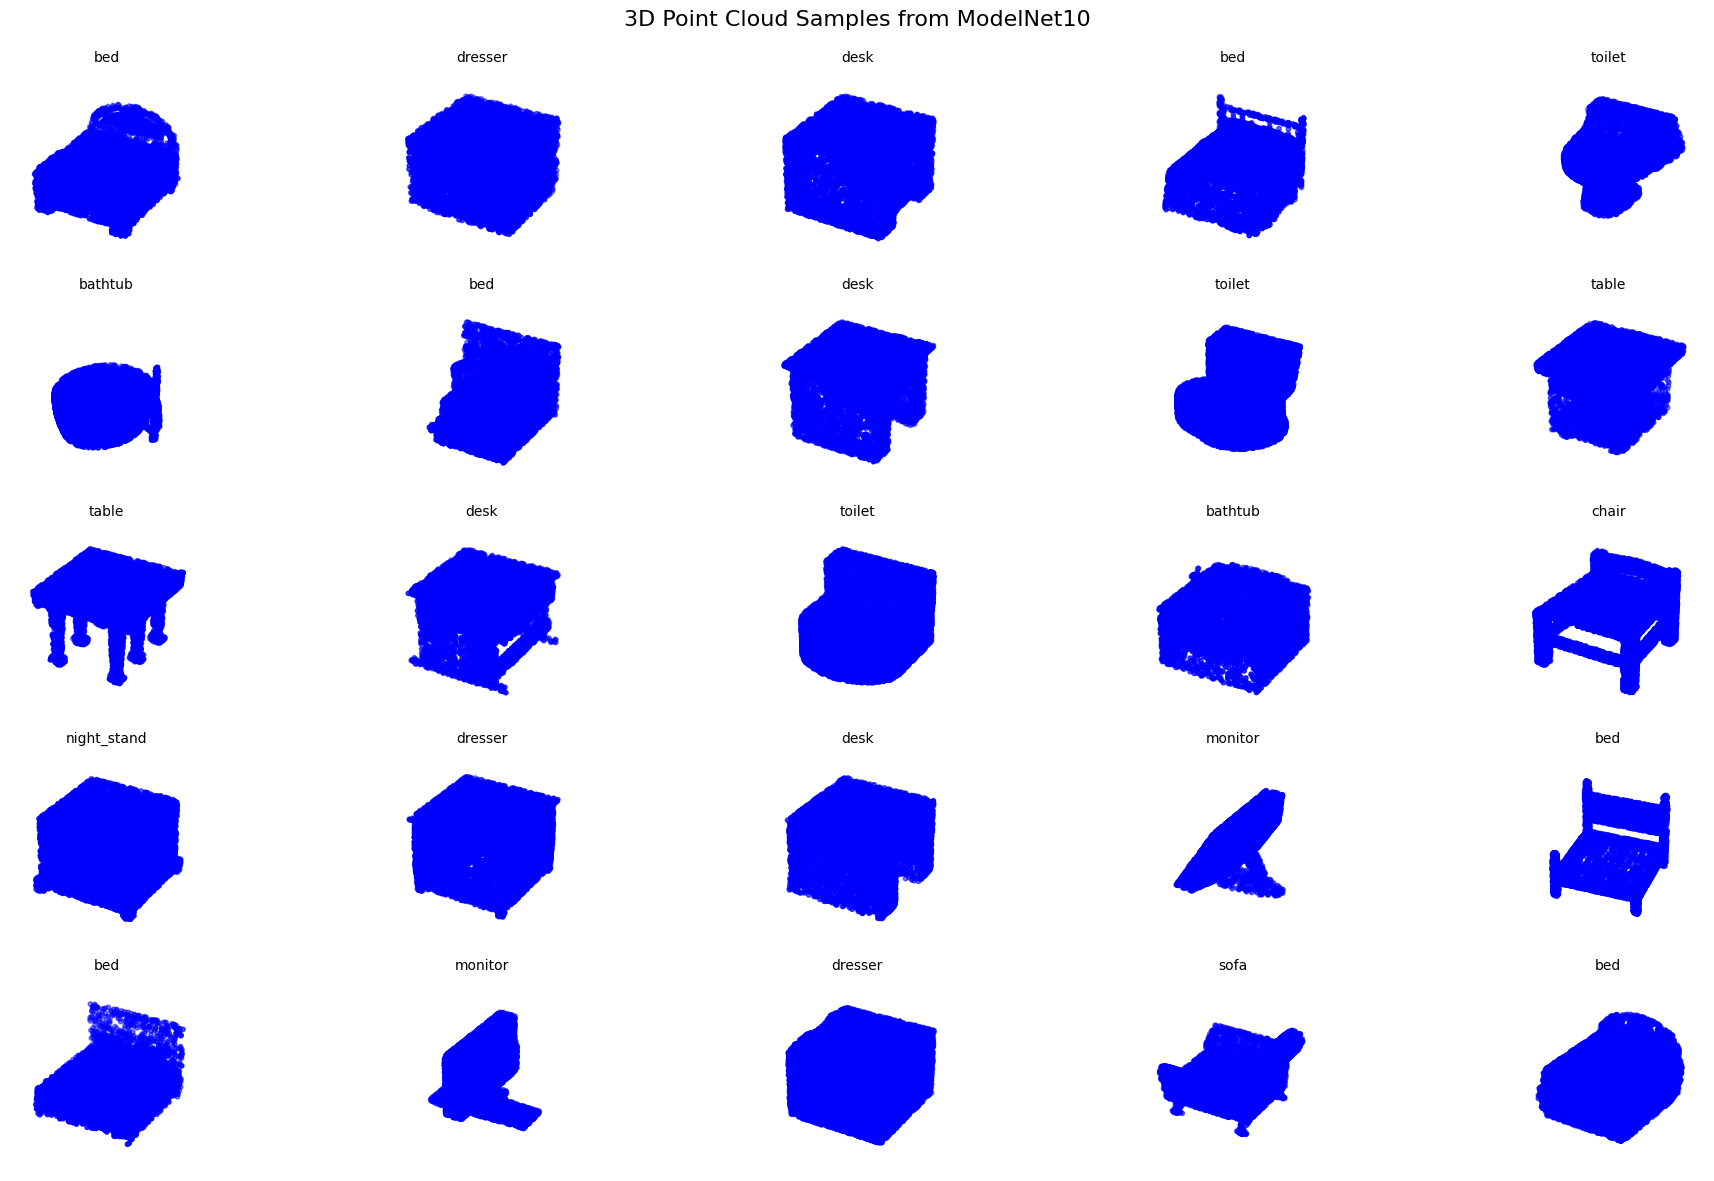

In [4]:
DATA_DIR = "/kaggle/working/MobileNet10"
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

fig, axes = plt.subplots(5, 5, figsize=(20, 12), subplot_kw={'projection': '3d'})
fig.suptitle("3D Point Cloud Samples from ModelNet10", fontsize=16)

for ax in axes.flatten():
    selected_class = random.choice(classes)
    train_path = os.path.join(DATA_DIR, selected_class, "train")
    mesh_files = [f for f in os.listdir(train_path) if f.endswith(".off")]
    
    if mesh_files:
        mesh_path = os.path.join(train_path, random.choice(mesh_files))
        mesh = trimesh.load_mesh(mesh_path)
        points = mesh.sample(10480)

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10, c="blue")
        ax.set_title(selected_class, fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# Visualize Some Images From Dataset

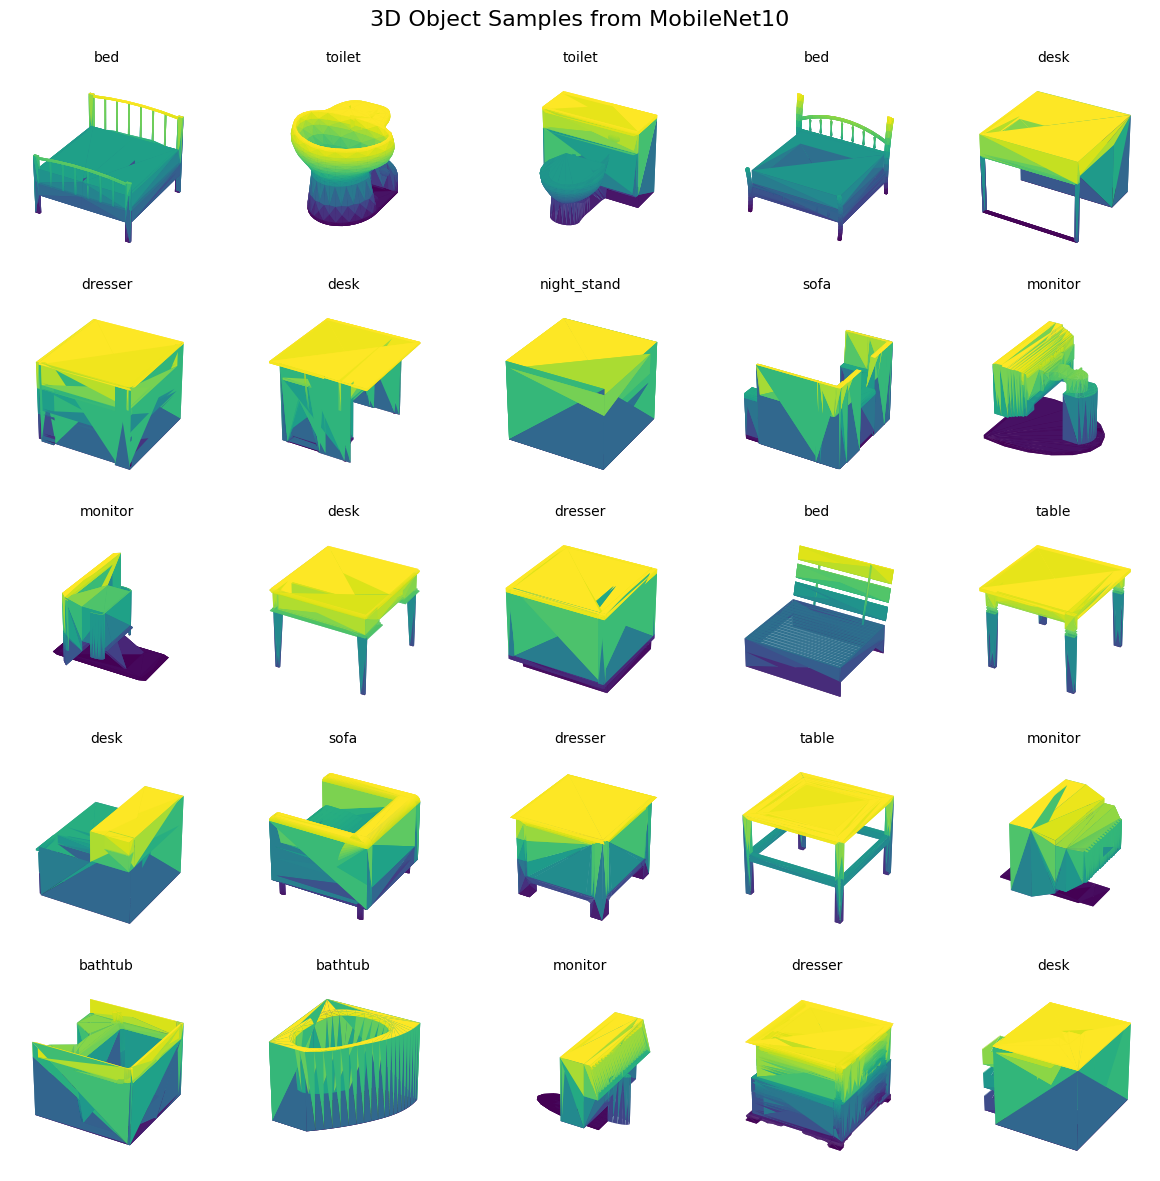

In [5]:

classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

fig, axes = plt.subplots(5, 5, figsize=(12, 12), subplot_kw={'projection': '3d'})
fig.suptitle("3D Object Samples from MobileNet10", fontsize=16)

for ax in axes.flatten():
    selected_class = random.choice(classes)
    train_path = os.path.join(DATA_DIR, selected_class, "train")
    mesh_files = [f for f in os.listdir(train_path) if f.endswith(".off")]
    
    if mesh_files:
        mesh_path = os.path.join(train_path, random.choice(mesh_files))
        mesh = trimesh.load_mesh(mesh_path)
        
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, cmap="viridis")
        ax.set_title(selected_class, fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# Compare Data Length

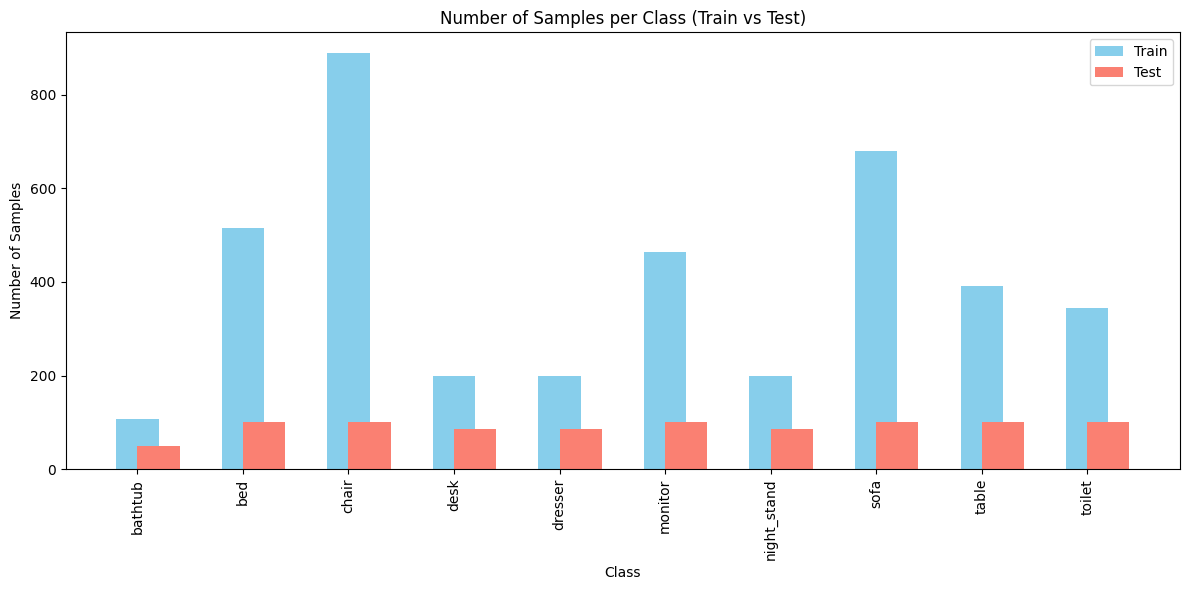

In [6]:

class_lengths = {}
for class_name in classes:
    train_path = os.path.join(DATA_DIR, class_name, "train")
    valid_path = os.path.join(DATA_DIR, class_name, "test")
    
    train_samples = len([f for f in os.listdir(train_path) if f.endswith(".off")])
    valid_samples = len([f for f in os.listdir(valid_path) if f.endswith(".off")])
    
    class_lengths[class_name] = {'train': train_samples, 'valid': valid_samples}

train_lengths = [class_lengths[class_name]['train'] for class_name in classes]
valid_lengths = [class_lengths[class_name]['valid'] for class_name in classes]

x = range(len(classes))

plt.figure(figsize=(12, 6))
plt.bar(x, train_lengths, width=0.4, label='Train', align='center', color='skyblue')
plt.bar(x, valid_lengths, width=0.4, label='Test', align='edge', color='salmon')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Train vs Test)')
plt.xticks(x, classes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


**To generate a tf.data.Dataset() we need to first parse through the ModelNet data folders. Each mesh is loaded and sampled into a point cloud before being added to a standard python list and converted to a numpy array. We also store the current enumerate index value as the object label and use a dictionary to recall this later.**

In [7]:
from tqdm import tqdm
import os
import glob
import numpy as np
import trimesh

def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(tqdm(folders, desc="Processing Classes")):
        class_map[i] = os.path.basename(folder)
        
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in tqdm(train_files, desc=f"Processing {class_map[i]} Train", leave=False):
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in tqdm(test_files, desc=f"Processing {class_map[i]} Test", leave=False):
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map)


### Set the number of points to sample and batch size and parse the dataset. This can take ~5minutes to complete.

In [8]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

Processing night_stand Train:  98%|█████████▊| 196/200 [00:04<00:00, 31.75it/s]
                                                                               
Processing table Train: 100%|██████████| 392/392 [00:17<00:00, 37.53it/s]
                                                                         
Processing sofa Train:  99%|█████████▉| 674/680 [00:59<00:00, 11.13it/s]
                                                                        
Processing monitor Train:  98%|█████████▊| 455/465 [00:10<00:00, 49.27it/s]
                                                                           
Processing dresser Train: 100%|██████████| 200/200 [00:13<00:00, 11.25it/s]
                                                                           
Processing desk Train: 100%|█████████▉| 199/200 [00:08<00:00, 17.18it/s]
                                                                        
Processing toilet Train: 100%|█████████▉| 343/344 [00:24<00:00, 16.25it/s]
                     

**Our data can now be read into a tf.data.Dataset() object. We set the shuffle buffer size to the entire size of the dataset as prior to this the data is ordered by class. Data augmentation is important when working with point cloud data. We create a augmentation function to jitter and shuffle the train dataset.**

In [9]:
def augment(points, label):
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype="float64")
    return keras.random.shuffle(points), label

train_size = int(len(train_points) * 0.8)

dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels)).shuffle(len(train_points)).map(augment)
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels)).shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_size).batch(BATCH_SIZE)


# Get a sample batch from the dataset

In [10]:

sample_train_batch = next(iter(train_dataset))
sample_val_batch = next(iter(validation_dataset))


# Print shapes
print(f"Train batch shape: {sample_train_batch[0].shape}, Labels shape: {sample_train_batch[1].shape}")
print(f"Validation batch shape: {sample_val_batch[0].shape}, Labels shape: {sample_val_batch[1].shape}")



Train batch shape: (32, 2048, 3), Labels shape: (32,)
Validation batch shape: (32, 2048, 3), Labels shape: (32,)


# Build a model
**Each convolution and fully-connected layer (with exception for end layers) consists of Convolution / Dense -> Batch Normalization -> ReLU Activation.**

**PointNet consists of two core components. The primary MLP network, and the transformer net (T-net). The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice. The first time to transform the input features (n, 3) into a canonical representation. The second is an affine transformation for alignment in feature space (n, 3). As per the original paper we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).**

**The main network can be then implemented in the same manner where the t-net mini models can be dropped in a layers in the graph. Here we replicate the network architecture published in the original paper but with half the number of weights at each layer as we are using the smaller 10 class ModelNet dataset.**

In [11]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=1e-4):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))


def tnet(inputs, num_features):
   
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(num_features * num_features,kernel_initializer="zeros",bias_initializer=bias,activity_regularizer=reg)(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
   
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = tnet(x, 128)
x = conv_bn(x, 128)
x = conv_bn(x, 256)
x = conv_bn(x, 512)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 512)
x = layers.Dropout(0.4)(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.4)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=3e-4,clipnorm=1.0), metrics=["accuracy"])

model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2048, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 2048, 32)       │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048, 32)       │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 2048, 32)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 2048, 64)       │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048, 64)       │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 2048, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 2048, 512)      │         33,280 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 2048, 512)      │          2,048 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 2048, 512)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ activation_2[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 3,947,891 (15.06 MB)

 Trainable params: 3,937,779 (15.02 MB)

 Non-trainable params: 10,112 (39.50 KB)

# Early stopping & Reduce Lr

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Model Train

In [13]:
history=model.fit(train_dataset, epochs=200, validation_data=validation_dataset,callbacks=[early_stopping,reduce_lr])

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.1655 - loss: 23.0703 - val_accuracy: 0.5119 - val_loss: 254141888724992.0000 - learning_rate: 3.0000e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.3336 - loss: 15.8079 - val_accuracy: 0.5557 - val_loss: 209948876285673472.0000 - learning_rate: 3.0000e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.4800 - loss: 15.1466 - val_accuracy: 0.5795 - val_loss: 14099228393472.0000 - learning_rate: 3.0000e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5581 - loss: 14.8165 - val_accuracy: 0.6008 - val_loss: 4936084695100121044484096.0000 - learning_rate: 3.0000e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.6236 - loss: 14.6303 - val_accuracy: 0.7572 - val_loss: 46412280627200.0000 - learning_rate: 3.0000e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6211 - loss: 14.5328 - val_accuracy: 0.7359 

# Loss & Accuracy Graph

In [14]:
def model_loss_and_accuracy(history):
    
    fig=plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(history.history["accuracy"],"b*--",label="accuracy")
    plt.plot(history.history["val_accuracy"],"r*--",label="val_accuracy")
    plt.title("Model Accuracy\n",fontsize=20,color="darkorange")
    plt.xlabel("Number of Epochs",color="midnightblue",fontsize=15)
    plt.ylabel("Accuracy",color="midnightblue",fontsize=15)
    plt.grid(color = 'green', linestyle = '--', linewidth = 1)
    plt.legend(loc="best")
    plt.tight_layout()
    
  
    plt.subplot(222)
    plt.plot(history.history["loss"],"b.--",label="loss")
    plt.plot(history.history["val_loss"],"r.--",label="val_loss")
    plt.title("Model Loss\n",fontsize=20,color="limegreen")
    plt.xlabel("Number of Epochs",color="midnightblue",fontsize=15)
    plt.ylabel("Loss",color="midnightblue",fontsize=15)
    plt.grid(color = 'green', linestyle = '--', linewidth = 1)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

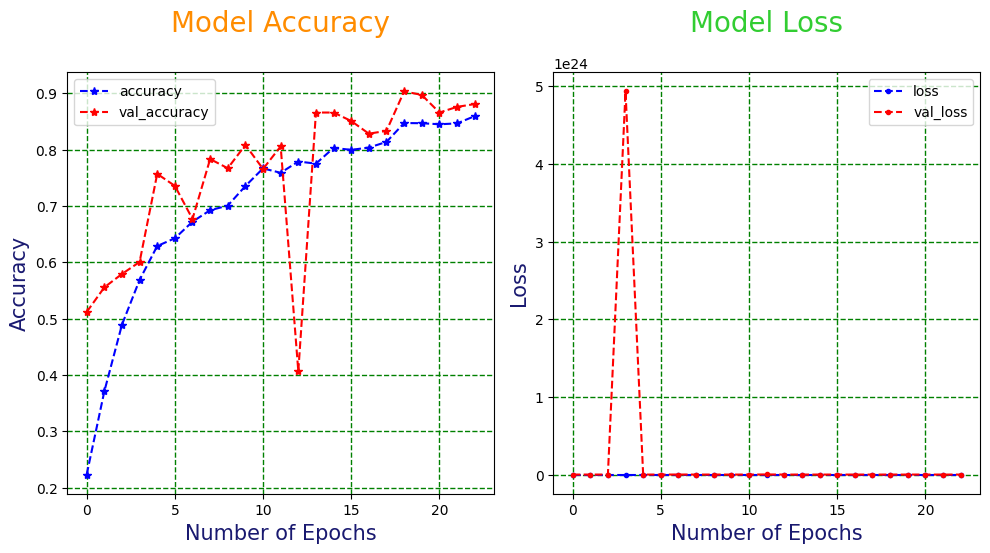

In [15]:
 model_loss_and_accuracy(history)

In [16]:
# Get unique class indices from validation labels
y_val = np.concatenate([y.numpy() for _, y in validation_dataset])
unique_labels = np.unique(y_val)

# Map labels to class names (assuming classes list exists)
class_names = [classes[i] for i in unique_labels]
print("Class Names:", class_names)

Class Names: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']


# Confusion Matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step


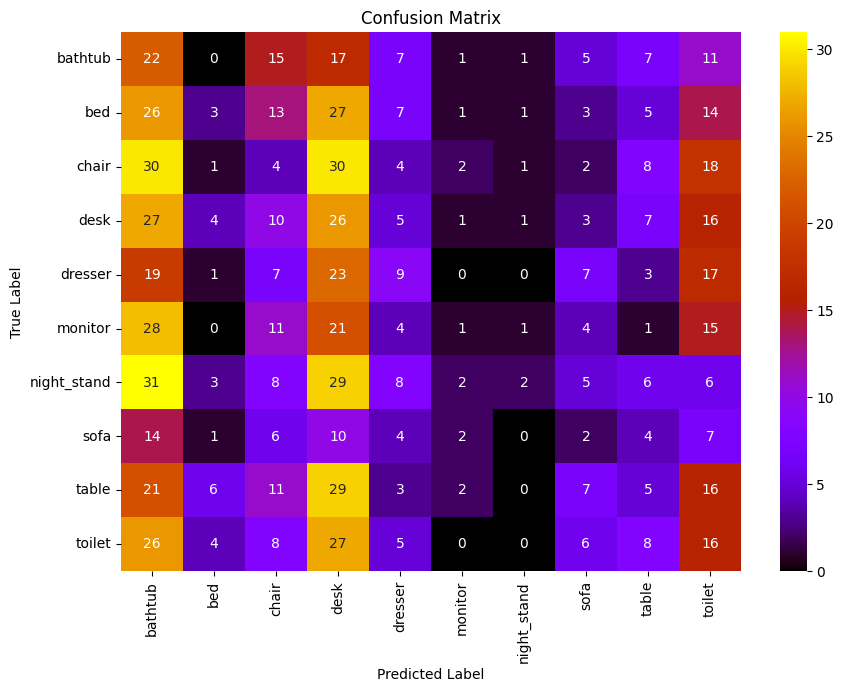

In [17]:
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report)

y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred = np.argmax(model.predict(test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="gnuplot", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report

In [18]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     bathtub       0.09      0.26      0.13        86
         bed       0.13      0.03      0.05       100
       chair       0.04      0.04      0.04       100
        desk       0.11      0.26      0.15       100
     dresser       0.16      0.10      0.13        86
     monitor       0.08      0.01      0.02        86
 night_stand       0.29      0.02      0.04       100
        sofa       0.05      0.04      0.04        50
       table       0.09      0.05      0.06       100
      toilet       0.12      0.16      0.14       100

    accuracy                           0.10       908
   macro avg       0.12      0.10      0.08       908
weighted avg       0.12      0.10      0.08       908



# Roc Curve

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


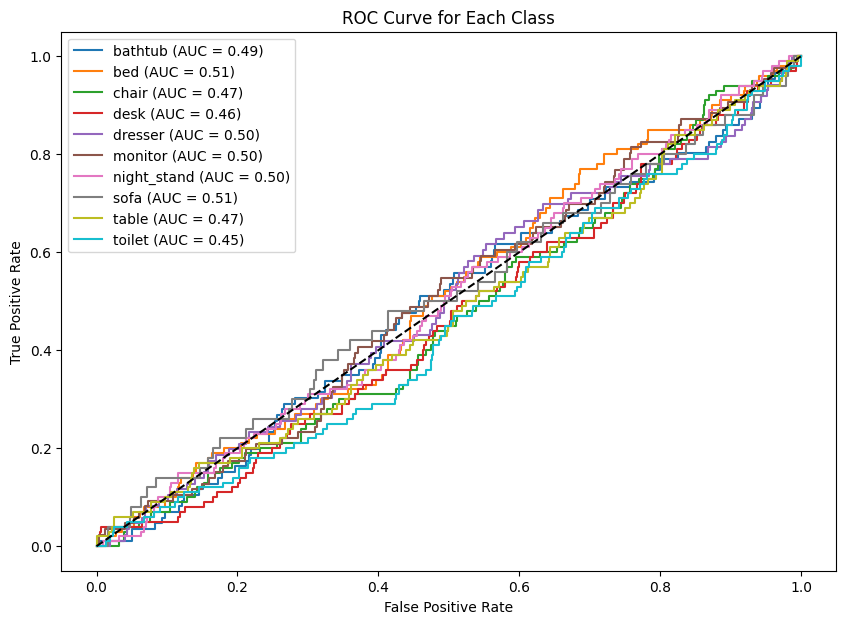

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred_proba = model.predict(test_dataset)

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend()
plt.show()


# Precision Recall Curve

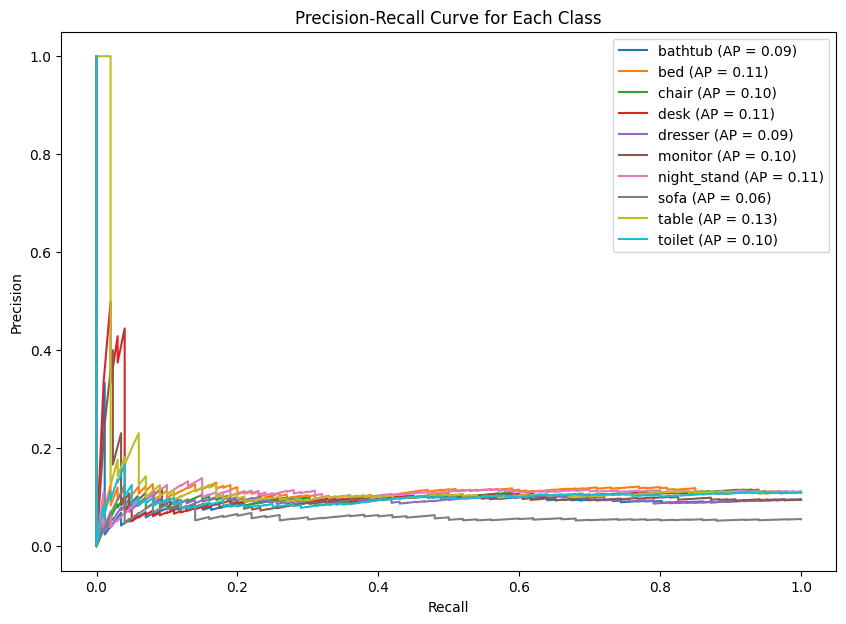

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()


# Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


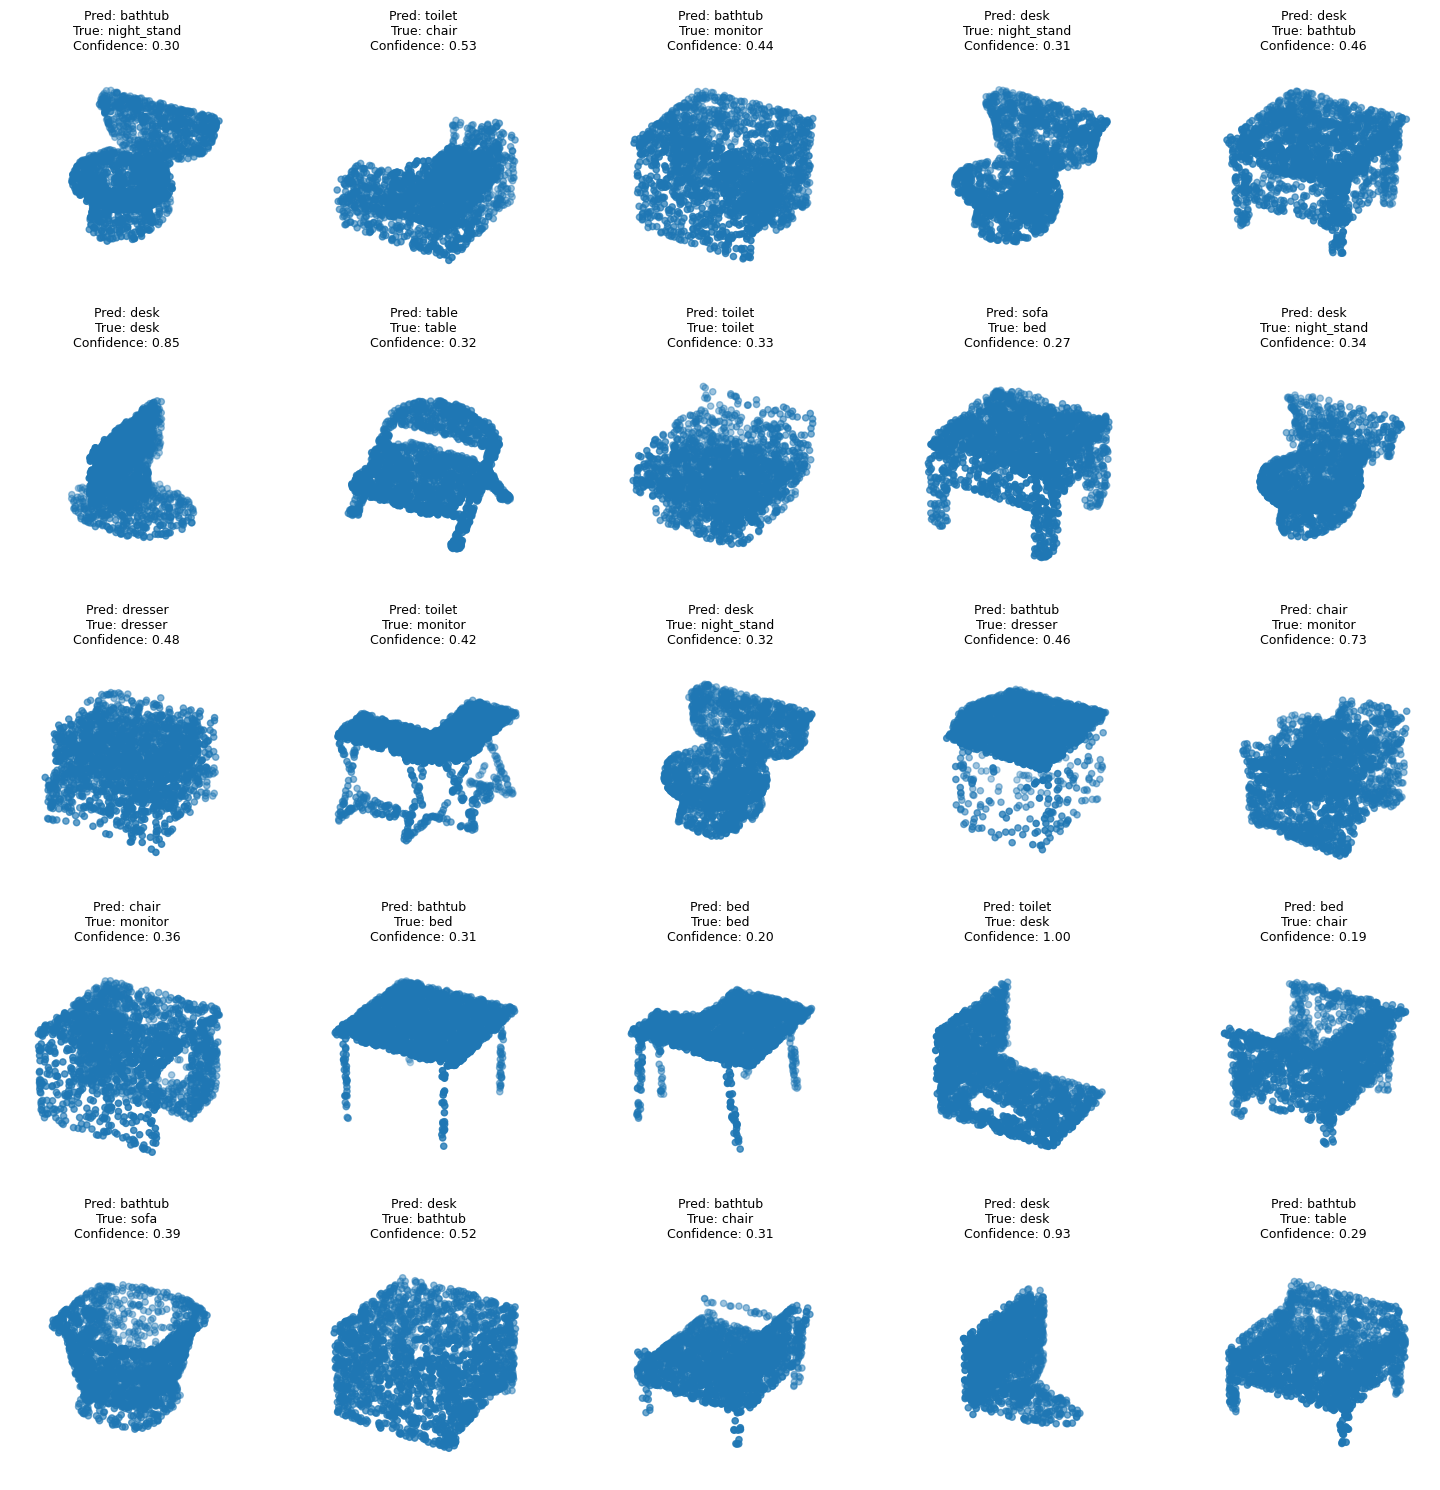

In [21]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:25, ...]
labels = labels[:25, ...]

preds = model.predict(points)
pred_labels = ops.argmax(preds, -1)
confidences = np.max(preds, axis=-1)

points = points.numpy()

fig = plt.figure(figsize=(15, 15))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title("Pred: {}\nTrue: {}\nConfidence: {:.2f}".format(class_names[pred_labels[i].numpy()],class_names[labels.numpy()[i]], confidences[i]),fontsize=9)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
